# AB Power Spectrum
$\tau_S=0.1,\,\epsilon=1.0$
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 11/12/2021|

## Python Imports

In [73]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
from astropy.io import fits
from astropy import units as u
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from turbustat.statistics import PowerSpectrum

# Saturation Morphology

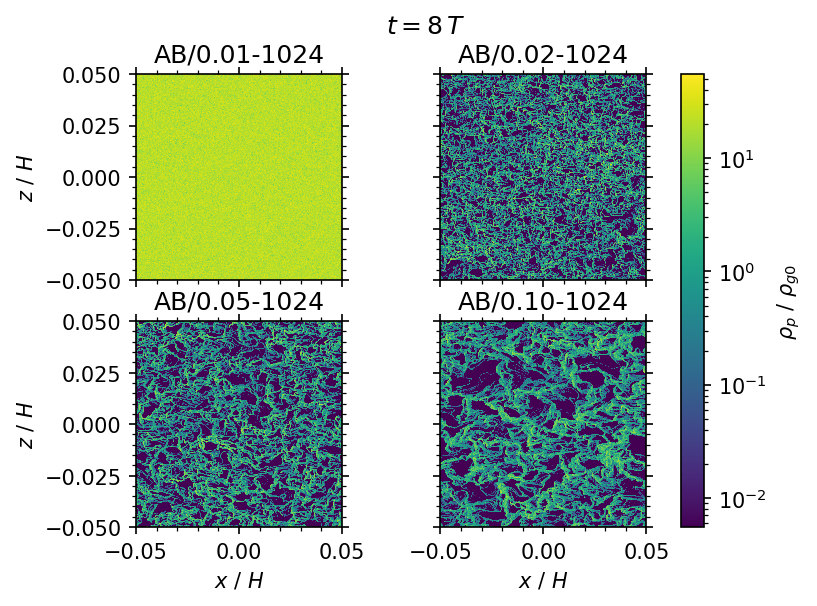

In [45]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
vmax, vmag = 0, 1e4

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%runs[i]\
                             +athinput["job"]["problem_id"]+'.out2.02000.athdf')
    if np.amax(data['rhop'][0]) > vmax:
        vmax = np.amax(data['rhop'][0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clip = np.clip(data['rhop'][0], vmax/vmag, vmax)
    
    # Plot
    img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
    ax.set(title=r'{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

# PowerSpectrum Options

**References**
- [TurbuStat](https://turbustat.readthedocs.io/en/stable/index.html)
  - [Spatial Power Spectrum Tutorial](https://turbustat.readthedocs.io/en/stable/tutorials/statistics/pspec_example.html)
  - [PowerSpectrum Class Documentation](https://turbustat.readthedocs.io/en/stable/api/turbustat.statistics.PowerSpectrum.html)

> Chao-Chin Yang:
> ```
> E(k) = E(sqrt(kx^2 + kz^2))
> E = a * conj(a)
> ```

In [46]:
run = 'AB/0.02-1024'

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
# c_s = athinput['hydro']['iso_sound_speed'] # sound speed
# Omega = athinput['problem']['omega']       # local Keplerian angular frequency
# H = c_s/Omega                              # gas scale height
# T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                         +athinput["job"]["problem_id"]+'.out2.02000.athdf')
img = fits.PrimaryHDU(data['rhop'][0])
# xf, zf = data['x1f']/H, data['x2f']/H
img.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  

### 2D Elliptical Power-Law Fit

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1325.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):          1.42e-165
Time:                        09:19:40   Log-Likelihood:                -32.275
No. Observations:                 724   AIC:                             68.55
Df Residuals:                     722   BIC:                             77.72
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2920      0.034    154.057      0.0

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


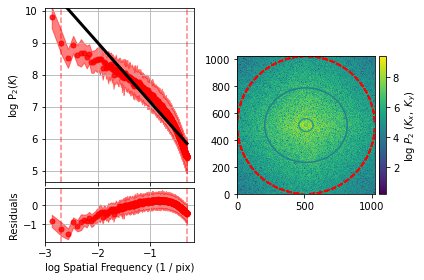

In [47]:
pspec = PowerSpectrum(img)
pspec.run(verbose=True, use_pyfftw=True, threads=4)

The dashed red lines (or contours) on both plots are the limits of the data used in the fits.
The dark blue-green contours on the 2D power spectrum are fit with the elliptical power-law model below:

$$
A\left[\left(q^{2} \cos ^{2} \theta+\sin ^{2} \theta\right) x^{2}+2\left(1-q^{2}\right) \sin \theta \cos \theta x y+\left(q^{2} \sin ^{2} \theta+\cos ^{2} \theta\right) y^{2}\right]^{1 / 2},
$$
where $\Gamma$ is the power-law index, $\theta$ is the orientation angle of the ellipse with respect to the $x$, $y$ coordinate system, and $q \in [0,\,1)$ is the flattening (i.e., ellipticity, oblateness).

In [48]:
print(f'Γ = {pspec.slope2D:0.2f} ± {pspec.slope2D_err:.1e}')
print(f'θ = {pspec.theta2D:5.2f} ± {pspec.theta2D_err:.1e}')
print(f'q = {pspec.ellip2D:5.2f} ± {pspec.ellip2D_err:.1e}')

Γ = -2.63 ± 3.0e-03
θ =  3.12 ± 7.2e-03
q =  0.90 ± 1.6e-03


### 1D Power-Law Fit

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1325.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):          1.42e-165
Time:                        09:19:44   Log-Likelihood:                -32.275
No. Observations:                 724   AIC:                             68.55
Df Residuals:                     722   BIC:                             77.72
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2920      0.034    154.057      0.0

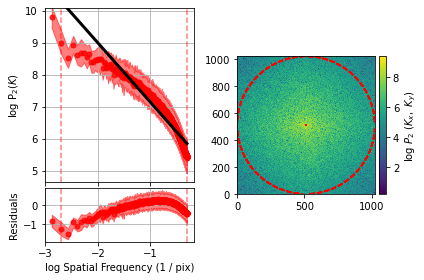

In [49]:
pspec = PowerSpectrum(img)
pspec.run(verbose=True, use_pyfftw=True, threads=4, fit_2D=False)

### Fit Range Limits

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1670.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           2.52e-79
Time:                        09:19:49   Log-Likelihood:                 184.92
No. Observations:                 141   AIC:                            -365.8
Df Residuals:                     139   BIC:                            -359.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4170      0.032    199.158      0.0

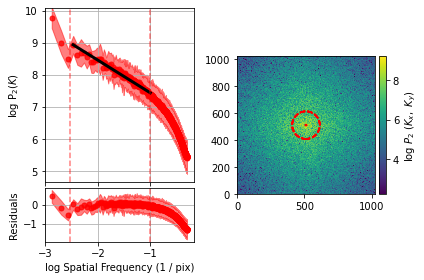

In [50]:
pspec = PowerSpectrum(img)
pspec.run(verbose=True, use_pyfftw=True, threads=4, xunit=u.pix**-1,
          low_cut=0.003/u.pix, high_cut=0.1/u.pix, fit_2D=False)

### Weighted Least Squares Fit

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            WLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1038.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.54e-66
Time:                        13:14:33   Log-Likelihood:                 171.32
No. Observations:                 140   AIC:                            -338.6
Df Residuals:                     138   BIC:                            -332.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4416      0.041    158.876      0.0

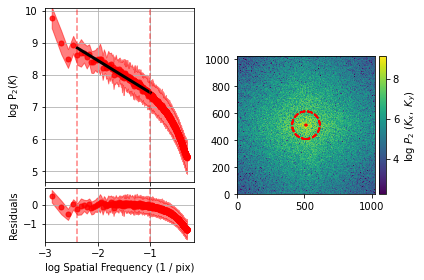

In [66]:
pspec = PowerSpectrum(img)
pspec.run(verbose=True, use_pyfftw=True, threads=4, xunit=u.pix**-1,
          low_cut=0.004/u.pix, high_cut=0.1/u.pix, fit_2D=False,
          fit_kwargs={'weighted_fit': True})

## Broken Power-Laws
> Breaks in the power-law behaviour in observations (and higher-resolution simulations) can result from differences in the physical processes dominating at those scales (e.g., [Swift & Welch 2008](https://ui.adsabs.harvard.edu/#abs/2008ApJS..174..202S/abstract))

[*Source*](https://turbustat.readthedocs.io/en/stable/tutorials/statistics/pspec_example.html#using)

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.581e+04
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:37:48   Log-Likelihood:                 953.53
No. Observations:                 722   AIC:                            -1899.
Df Residuals:                     718   BIC:                            -1881.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1128      0.012    489.945      0.0

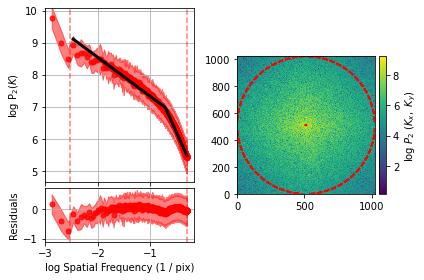

In [58]:
pspec = PowerSpectrum(img)
pspec.run(verbose=True, use_pyfftw=True, threads=4, xunit=u.pix**-1,
          low_cut=0.003/u.pix, fit_2D=False,
          fit_kwargs={'brk': 0.1 / u.pix, 'log_break': False})

In [59]:
print(f' k₁ = {pspec.slope[0]:0.2f} ± {pspec.slope_err[0]:.1e}')
print(f' k₂ = {pspec.slope[1]:5.2f} ± {pspec.slope_err[1]:.1e}')
print(f'brk = {pspec.brk:5.2f} ± {pspec.brk_err:.1e}')

 k₁ = -1.21 ± 1.1e-02
 k₂ = -3.63 ± 3.0e-02
brk =  0.19 1 / pix ± 4.0e-03 1 / pix


# $K$ vs. $\Pi$ Fit

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            WLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1038.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.54e-66
Time:                        14:28:49   Log-Likelihood:                 171.32
No. Observations:                 140   AIC:                            -338.6
Df Residuals:                     138   BIC:                            -332.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4416      0.041    158.876      0.0

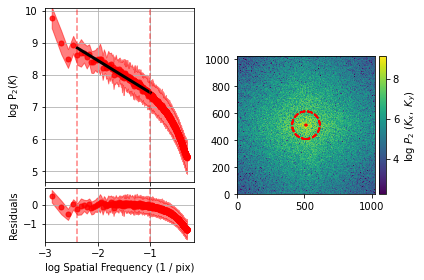

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            WLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     531.0
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.80e-49
Time:                        14:29:02   Log-Likelihood:                 131.74
No. Observations:                 140   AIC:                            -259.5
Df Residuals:                     138   BIC:                            -253.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1635      0.071     86.631      0.0

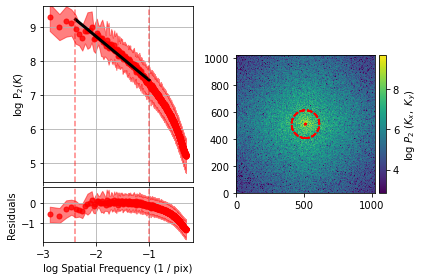

/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/stanley/miniconda3/envs/athena/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     3049.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           5.73e-96
Time:                        14:29:20   Log-Likelihood:                 166.69
No. Observations:                 140   AIC:                            -329.4
Df Residuals:                     138   BIC:                            -323.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5738      0.039    142.230      0.0

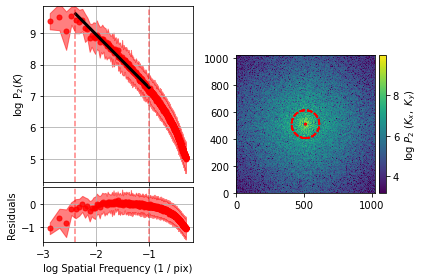

,Run,𝐾,𝜎ₖ
0,AB/0.02-1024,-1.0,3.1e-02
1,AB/0.05-1024,-1.3,5.6e-02
2,AB/0.10-1024,-1.7,3.1e-02


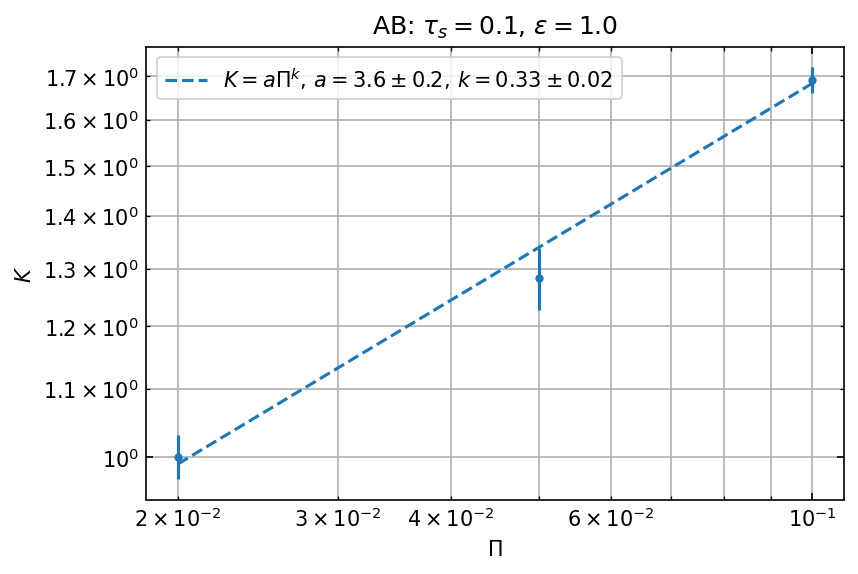

In [82]:
title = 'AB'
runs = ['AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
Πs, ks, σks = np.zeros(len(runs)), np.zeros(len(runs)), np.zeros(len(runs))
func = lambda x, a, k : a*x**k # power-law model function

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                         +athinput["job"]["problem_id"]+'.out2.02000.athdf')
    img = fits.PrimaryHDU(data['rhop'][0])
    pspec = PowerSpectrum(img)
    pspec.run(verbose=True, use_pyfftw=True, threads=4, xunit=u.pix**-1,
          low_cut=0.004/u.pix, high_cut=0.1/u.pix, fit_2D=False,
          fit_kwargs={'weighted_fit': True})
    ks[i], σks[i] = pspec.slope, pspec.slope_err

fig, ax = plt.subplots(dpi=150)
popt, pcov = curve_fit(func, Πs, np.abs(ks), sigma=σks)
perr = np.sqrt(np.diag(pcov))
label = r'$K=a\Pi^k,\,a={:.1f}\pm{:.1f},\,k={:.2f}\pm{:.2f}$'.format(
        popt[0], perr[0], popt[1], perr[1])
ax.errorbar(Πs, np.abs(ks), σks, fmt='.')
ax.plot(Πs, func(Πs, *popt), ls='--', color='tab:blue', label=label)
ax.set(xlabel=r'$\Pi$', ylabel=r'$K$', xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '𝐾': ks,
    '𝜎ₖ': σks,})
df.style.format({
    '𝐾': '{:.1f}',
    '𝜎ₖ': '{:.1e}',})